In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [46]:
def get_data():
    df = pd.read_excel('full_index(1).xls').reset_index(drop=True)
    df = df.set_index('Year').T

    target_col = ['RDBRFCategoryID']
    cols = []
    for i in range(2, len(df.columns) - 1):
        ij = df.columns[i]
        if (str(ij) == 'nan'):
            continue
        if df[ij][2004] != None:
            cols.append(df.columns[i])
    X, y = df[cols].values, df[target_col].values
    return X, y.flatten()

In [102]:
def glm_fit(X, target):
    model = sm.GLM(target, X, family=sm.families.Binomial())
    result = model.fit(method_kwargs={'warn_convergence': False})
    return result

def learnPartialOrders(X, y):
    labels = np.unique(y)
    num_rows, num_cols = X.shape[0], X.shape[1]
    partialOrderMat = np.zeros([num_rows ** 2, num_cols])
    
    for i in range(num_cols):
        curVec = X[:, i]
        firstMat = np.tile(curVec[:, np.newaxis], (1, len(curVec)))
        secondMat = np.tile(curVec[np.newaxis, :], (len(curVec), 1))
        current_mat = np.greater_equal(firstMat, secondMat).astype(float)
        
        zero_idx = np.where(curVec == 0)[0]
        current_mat[zero_idx, :] = 0
        current_mat[:, zero_idx] = 0
        
        partialOrderMat[:, i] = current_mat.flatten()

    firstMat = np.tile(y[:, np.newaxis], (1, len(y)))
    secondMat = np.tile(y[np.newaxis, :], (len(y), 1))
    yMat = np.greater_equal(firstMat, secondMat).astype(float)
    y_vec = np.reshape(yMat, [yMat.shape[0] ** 2, 1])
    
    model = sm.GLM(y_vec, partialOrderMat, family=sm.families.Binomial())
    result = model.fit()
    w0 = result.params

    y_est = result.predict(partialOrderMat)
    y_mat_est = np.reshape(y_est, [len(y), len(y)])
    
    y_mat_est_conv = np.zeros((y_mat_est.shape[0], len(labels)))
    for class_idx in range(len(labels)):
        y_mat_est_conv[:, class_idx] = np.sum(y_mat_est[:, y == labels[class_idx]], axis=1)
    
    par_w = np.zeros([y_mat_est_conv.shape[1], len(labels) - 1])
    for class_idx in range(len(labels) - 1):
        y_curr = (y > labels[class_idx]).astype(float)
        par_w[:, class_idx] = glm_fit(y_mat_est_conv, y_curr).params

    return w0, par_w

In [117]:
def testPartialOrders(X_learn, y_learn, X_test, w0, par_w):
    labels = np.array([0, 1, 2, 3, 4, 5, 6])

    y_fit = np.zeros((X_test.shape[0], len(labels) - 1))
    y_est = np.ones(X_test.shape[0])

    for idx_test in range(X_test.shape[0]):
        x_test_obj = X_test[idx_test]
        x_test_obj_mat = np.tile(x_test_obj, (X_learn.shape[0], 1))
        
        # Создание матрицы частичного порядка
        partial_order_mat = (x_test_obj_mat >= X_learn).astype(float)
        partial_order_mat[X_learn == 0] = 0
        #partial_order_mat[x_test_obj_mat == 0] = 0
        
        # Прогнозирование с помощью glmval
        y_est0 = sm.families.Binomial().link.inverse(w0.dot(partial_order_mat.T))
        
        y_vec_conv = np.zeros(len(labels))
        
        for cl_idx in range(len(labels)):
            y_vec_conv[cl_idx] = np.sum(y_est0[y_learn == labels[cl_idx]])
        
        for cl_idx in range(len(labels) - 1):
            y_fit[idx_test, cl_idx] = sm.families.Binomial().link.inverse(par_w[:, cl_idx].dot(y_vec_conv))
    
    # Преобразование y_fit
    y_fit = np.column_stack((1 - y_fit[:, 0], 
                              y_fit[:, 1:] - np.roll(y_fit[:, 1:], shift=1, axis=1),
                              y_fit[:, -1]))
    
    y_est = np.argmax(y_fit, axis=1)
    return y_est

In [119]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

w0, w = learnPartialOrders(X_learn, y_learn)

res = testPartialOrders(X_learn, y_learn, X_test, w0, w)

MAE = np.mean(np.abs(y_test - res))

C:\Users\Home\AppData\Local\Temp\ipykernel_13552\1345495246.py:15: RuntimeWarning: invalid value encountered in greater_equal
  current_mat = np.greater_equal(firstMat, secondMat).astype(float)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Home\AppData\Local\Temp\ipykernel_1355

In [121]:
y_test

array([4, 2, 1, 2, 2, 1, 1, 1, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2,
       3, 2, 3, 3, 3, 3, 3, 3, 0, 1, 3, 0, 3, 4, 3, 2, 3, 3, 2, 1, 2, 1,
       1, 3], dtype=object)

In [122]:
res

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 6, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1], dtype=int64)

In [120]:
MAE

1.391304347826087

In [118]:
X, y = get_data()
yLoo_est = np.zeros(len(y))

for i in range(X.shape[0]):
    X_learn = np.vstack((X[:i], X[i + 1:]))
    y_learn = np.array(list(y[:i]) +  list(y[i+1:]))
    #y_learn = np.vstack((y[:i], y[i + 1:]))
    X_test = X[i, :]
    y_test = y[i]

    w0, w = learnPartialOrders(X_learn, y_learn)
    #print(testPartialOrders(X_learn, y_learn, X_test, w0, w))
    yLoo_est[i] = np.mean(testPartialOrders(X_learn, y_learn, X_test, w0, w))

MAE = np.mean(np.abs(y - yLoo_est))
    #X_learn = X[1:i - 1, i + 1 : X.shape[0]

C:\Users\Home\AppData\Local\Temp\ipykernel_13552\1345495246.py:15: RuntimeWarning: invalid value encountered in greater_equal
  current_mat = np.greater_equal(firstMat, secondMat).astype(float)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction

ValueError: shapes (6,) and (7,) not aligned: 6 (dim 0) != 7 (dim 0)

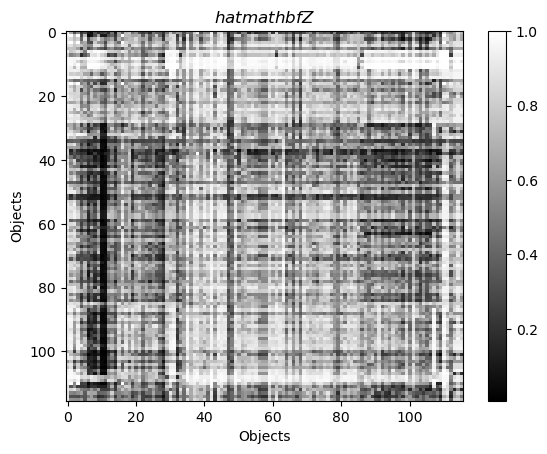

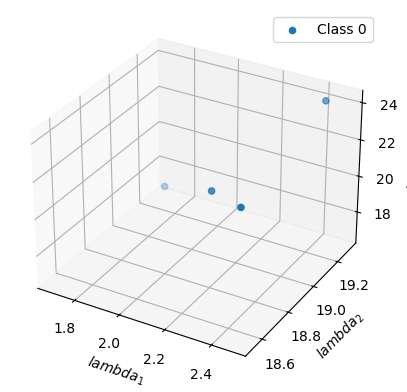

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


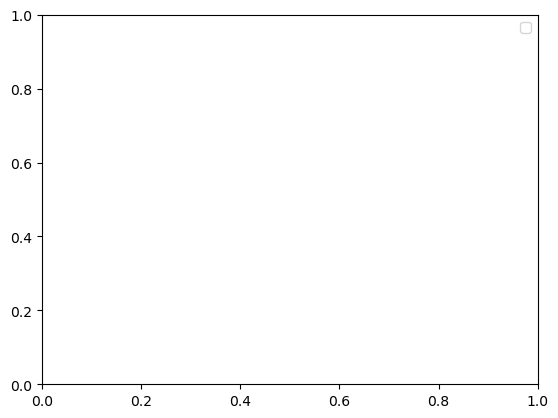

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


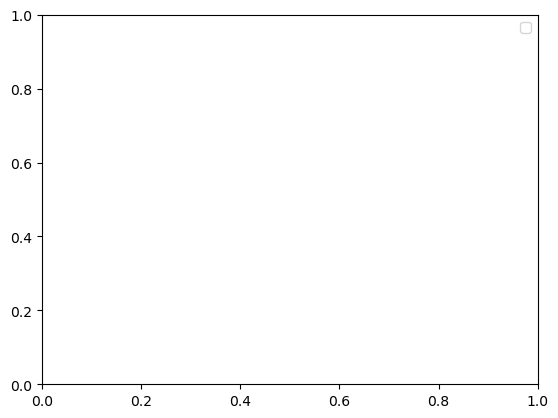

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


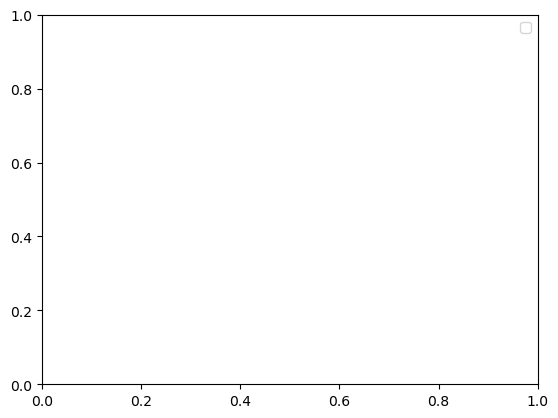

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


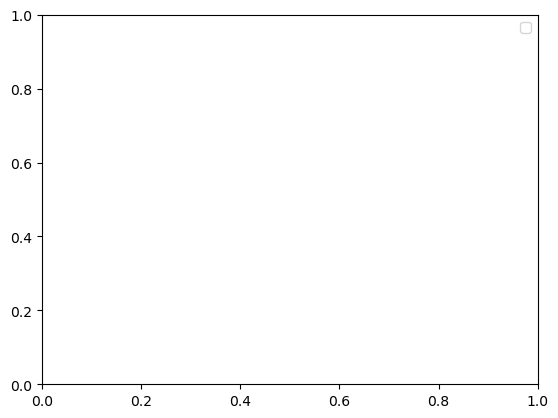

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


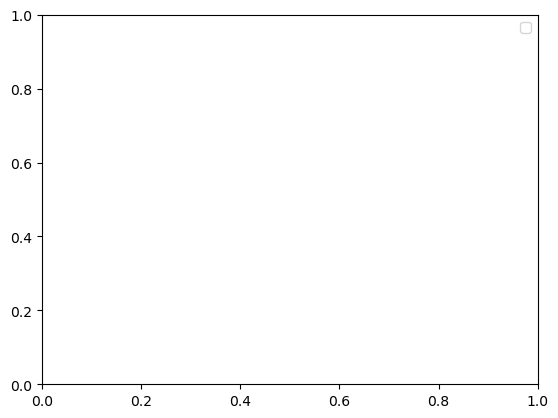

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


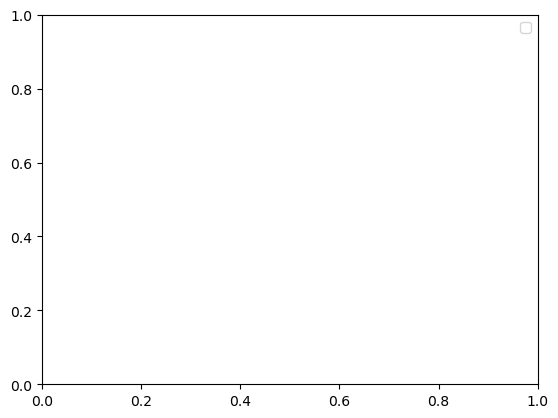

In [86]:
plt.figure()
plt.imshow(y_mat_est, aspect='auto', cmap='gray')
plt.colorbar()
plt.title(r'$hat{mathbf{Z}}$')
plt.xlabel('Objects')
plt.ylabel('Objects')
plt.show()

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_idx in range(len(labels)):
    ax.scatter(y_mat_est_conv[y == labels[class_idx], 0],
    y_mat_est_conv[y == labels[class_idx], 1],
    y_mat_est_conv[y == labels[class_idx], 2], label=f'Class {labels[class_idx]}')
        
    ax.set_xlabel(r'$lambda_1$')
    ax.set_ylabel(r'$lambda_2$')
    ax.set_zlabel(r'$lambda_3$')
    plt.legend()
    plt.show()